In [14]:
import requests
from urllib.request import urlopen
from urllib.parse import urlencode,unquote,quote_plus
import urllib
import lxml
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import time
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from konlpy.tag import Mecab
from khaiii import KhaiiiApi

import pandas as pd
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec

from konlpy.tag import Okt
from konlpy.tag import Mecab
from khaiii import KhaiiiApi

import numpy as np
from collections import Counter
import re
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from wordcloud import WordCloud
from PIL import ImageFont, ImageDraw

import matplotlib.pyplot as plt

from matplotlib import font_manager

In [2]:
# 재해개요 Data Load
df = pd.read_excel("fire_data.xlsx")
df


,연번,기준연월,발생형태_소,재해개요
0,43,201212,화재,주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징...
1,120,201212,폭발·파열,[비보고 사유] 가스주입실에서 이송대기중 질소가스통 체결부위 불량으로 폭발되면서 파...
2,197,201212,폭발·파열,[비보고 사유] 재해 발생시 산업재해발생 보고를 해야 한다는 사실을 알지 못함 [조...
3,394,201212,폭발·파열,[비보고 사유] 재해자가 본인 실수로 다쳤으므로 본인이 알아서 한다고 하여 방치한 ...
4,478,201212,폭발·파열,[비보고 사유] 공상처리 [조사자 견해] 유성기업(주)에서 제출한 공상처리 내역 및...
...,...,...,...,...
1814,495010,201712,화재,상기일 상기인 호스를 연결하기 위해 녹이는 과정에서 사고가 발생.(신나에 불이 옮겨...
1815,495567,201712,화재,12월 07일 오전07시경 제품(무거리) 보관용기로 사용하기 위해 폐드럼통 뚜껑 산...
1816,495930,201712,폭발·파열,2017년 12월 12일 14시 48분경 회사 공장동에서 기계시운전을 하면서 온도상...
1817,496127,201712,화재,2017년 12월 18일 13시경 부산시 강서구 송정동 소재 부광화학공업(주) 본공...


In [3]:
# 불용어 정의
df_stopwords = pd.read_excel('stopwords.xlsx')
df_stopwords

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
1142,확인
1143,응급
1144,이용
1145,직원


In [8]:
# 카카오에서 개발한 형태소 분석기 KhaiiiApi
api = KhaiiiApi()
sentence_list = []
morphs_list = []
df = pd.read_excel("fire_data.xlsx")
df_stopwords = pd.read_excel('stopwords.xlsx')
stopwords = list(df_stopwords['불용어'])


for sentence in df["재해개요"]:
    if sentence != '':
        # 모든 문장
        if '.' in sentence:
            sentence_detail = sentence.split('. ')
            for i in sentence_detail:
                if i != '':
                    sentence_list.append(i)
        else:
            sentence_list.append(sentence)

# for s in sentence_list:
#     print(s)
#     print()
# print(sentence_list[0])
# len(sentence_list)

주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징 기계를 이용하여 작업하던 중 가우징 불똥이 내경 단차부위에 두딪혀 작업자 쪽으로 뛰어 점퍼에 불이 붙었으나, 방독마스크와 용접면을 쓰고 있어서 불이 붙은 줄 모르다가 늦게 인지하여 왼쪽팔과 가슴쪽에 화염화상을 입음.

[비보고 사유] 가스주입실에서 이송대기중 질소가스통 체결부위 불량으로 폭발되면서 파편에 복부를 강타하여 부상을 입고 병원 치료를 하여 국민건강보험공단으로부터 부당이득금 환수조치된 건임 [조사자 견해] 법규정을 몰랐고 사고가 경미하여 산업재해조사표를 제출하지 않은 건으로 최근 3년이내 산재발생미보고로 처분 받은 사실이 없으므로 경고조치 후 종결코자 합니다

※ 붙임: 산재발생미보고 경위서 및 산업재해조사표 [작업장소] 사업장 내 가수주입실 [작업목적] 가스주입 후 이동대기 중 [작업도구] 가스주입기 [작업내용] 이송대기 적재중에 [재해사유] 체결부위 미세불량으로 [재해발생] 체결이 분리되면서 파편이 복부강타

[비보고 사유] 재해 발생시 산업재해발생 보고를 해야 한다는 사실을 알지 못함 [조사자 견해] 경고 조치를 하고자 함 [작업장소] 상기 사업장 내에서 [작업목적] 불을 피우기 위하여 [작업도구] 락카통을 사용하여 [작업내용] 부주의로 [재해사유] 없음 [재해발생] 락카통이 폭발하여 얼굴에 화상을 입음

[비보고 사유] 재해자가 본인 실수로 다쳤으므로 본인이 알아서 한다고 하여 방치한 것으로, 담당자가 산재처리 절차에 미숙하여 건강보험공단 환수처리로 마무리된 것으로 오인함

[조사자 견해] 재해정도가 경미하고 사업주의 고의성이 없는 것으로 판단하여 경고 조치후 종결하고자 합니다 [작업장소] 작업장내에서 [작업목적] 휴식중 추위를 피하기 위해 [작업도구] 불을 피우기 위해 [작업내용] 스레기 등을 모아 [재해사유] 불을 붙였다가 [재해발생] 더미속에 섞인 락카가 폭발하면서 목에 화상을 입음

[비보고 사유] 공상처리 [조사자 견해] 유성기업(주)에서 제출한 공상처


14:30경 순천 서면 구상리 171번지에서 파쇄 작업 관련하여 산소 절단 작업중 절단기 호스에 불이 붙어 화상을 입은 사고였음.

S736 E/R 방청유 도포된 No.1 M.G.O STOR TANK내 탑재 JOINT(작업 높이 약10m)용접 작업중 비산된 불꽃이 SCALLOP을 통과해 직하부 가연물에 점화되면서 징크 스프레이통이 파열되는 화재로 인해 이산화탄소 중독된 사고임.

2014년 5월 24일 12시 30분경 회사공장에서 작업 도중 알코올에 불이 붙어 전신화상을 당함

보일러 파손으로 인하여 충격으로 주저앉으며 얼굴부위 상처를 입음.
- 현장에서 떡을 찜하기 위해 보일러 증기 사용중 떡시루를 데우는 중 보일러 폭발로 인하여 뒤로 넘어지기도 하면서 얼굴 오른쪽 턱부근에 상처를 당했음

2014년 06월 02일 낯 12시경 플라스틱 PET 용기 라벨링 작업(라벨6호기) 중 본드 나오는 파이프가 막혀
신나로 청소하다가 스파크가 일어나면서 불이 붙어 화재가 발생하면서 얼굴 부위에 화상을 입음

2014.06.02 원단 염색을 위해 염료통에 염료를 녹여 넣고 빙초산을 투여하여야 하나 실수로 염료 끓인 물에 빙초산을 넣어 화학 반응으로 폭발과 함께 수상

재해자 정선호씨가 2014년 06월 04일 (주)메디진 유기합성 실험실에서 (대전시 유성구 전민동 461-6 한남대학교 산학협력단 건물 4층 407호) 유기합성 실험을 하던 중 합성과정 중 갑자기 불길이 올라와 후드에 불이 나면서 얼굴과 팔쪽에 불이 닿아 화상을 입었습니다.

2014년 6월 6일 20시 20분경 국일금속 사업장에서 주조실 안에서 작업을 하던 중, 소송노 기계 폭파로 인해 화재 발생 아스카 환자가 화상을 입어 119로 후송함.

2014년6월7일 오후 2시30분경 진천읍 송두4길 47-8 사업장에서 작업중 플라스틱 드럼통을 투입하여 분쇄하는 분쇄기계 안에 투입하면서 안에서 유증기에 의한 과부하 작용으로 인하여 폭발하여 기계 덮개 및 주위에 있는 철판에 의해 덮쳐서 사고가 발생함.

2014.0

2561

In [11]:
morphs_list = []
sentence_nouns_list = []
one = []
api = KhaiiiApi()
# 모든 문장에서 명사만 추출
for sentence in df.get("재해개요"):
#     print(sentence)
    morphs_value = []
    
    for word in api.analyze(sentence):
        for morph in word.morphs:
            if morph.tag == 'NNG' and morph.lex not in stopwords: # 명사 추출, 불용어 제거
                if len(morph.lex) == 1:
                    morph.lex = morph.lex+'_' # 한글자 명사 2글자로
                    one.append(morph.lex)
                morphs_list.append(morph.lex)
                morphs_value.append(morph.lex)
    sentence_nouns_list.append(morphs_value) # 각 문장별 명사 리스트 구별
morphs_list # 행 구분 없이 전체 단어 리스트 
print(sentence_nouns_list) # 행 구분한 전체 단어 리스트 


[['주조', '사업', '가우징', '안쪽', '소착', '제거', '기계', '불똥', '내경', '단차부위', '점퍼', '방독마스크', '용접면', '인지', '왼쪽팔', '가슴', '화상'], ['사유', '가스주입실', '대기', '질소가스통', '체결', '부위', '불량', '폭발', '파편', '복부', '강타', '부상', '치료', '국민', '건강', '보험', '공단', '부당', '이득금', '환수', '조치', '건임', '조사자', '견해', '법_', '규정', '경미', '재해조사표', '제출', '최근', '산재', '발생미보고', '처분', '사실', '경고', '조치', '종결', '코자', '붙임', '산재', '발생미', '경위서', '재해조사표', '가수', '입실', '목적', '가스주입', '대기', '가스주입기', '내용', '이송대기', '적재', '사유', '체결', '부위', '미세', '불량', '체결', '분리', '파편', '복부', '강타'], ['사유', '재해발생', '보고', '사실', '조사자', '견해', '경고', '조치', '장소', '상기', '목적', '락카통', '내용', '주의', '사유', '재해발생', '락카통', '폭발', '화상'], ['사유', '실수', '방치', '담당자', '산재', '처리', '절차', '건강', '보험', '공단', '환수', '처리', '마무리', '오인', '조사자', '견해', '정도', '사업주의', '고의', '판단', '경고', '조치', '종결', '장소', '장내', '목적', '휴식', '추위', '내용', '스레기', '사유', '더미속', '락카', '폭발', '화상'], ['사유', '공상', '처리', '조사', '견해', '제출', '공상', '처리', '내역', '재해조사표', '결과', '해임', '공상', '처리', '보고기', '과태료', '부과', '조치코', '주조', '전기', '목적', '포대', '자루', 

In [12]:
# print(morphs_list)

In [17]:
nouns_counter = Counter(morphs_list)
top_nouns = dict(nouns_counter.most_common(100))

In [18]:
top_nouns

{'화상': 1069,
 '폭발': 683,
 '용접': 293,
 '가스': 258,
 '소재': 254,
 '산소': 215,
 '절단': 212,
 '현장': 209,
 '치료': 178,
 '불꽃': 169,
 '기계': 162,
 '옷_': 158,
 '드럼통': 157,
 '탱크': 129,
 '절단기': 125,
 '제거': 123,
 '부위': 121,
 '회사': 118,
 '제품': 112,
 '상태': 106,
 '용기': 104,
 '호스': 98,
 '상기': 97,
 '차량': 96,
 '바닥': 95,
 '진압': 92,
 '작업복': 90,
 '공정': 88,
 '연결': 87,
 '스파': 86,
 '후송': 85,
 '유증기': 84,
 '투입': 82,
 '가열': 79,
 '소리': 77,
 '전기': 75,
 '추정': 75,
 '소화기': 75,
 '청소': 75,
 '준비': 73,
 '발화': 73,
 '수리': 73,
 '진화': 72,
 '세척': 72,
 '압력': 71,
 '당사': 69,
 '근무': 69,
 '바지': 69,
 '점화': 67,
 '원료': 67,
 '누출': 66,
 '부상': 65,
 '뚜껑': 65,
 '처리': 64,
 '장갑': 63,
 '건조': 61,
 '대피': 60,
 '배관': 59,
 '정전기': 59,
 '교체': 58,
 '제조': 58,
 '스프레이': 57,
 '점검': 57,
 '파편': 56,
 '토치': 56,
 '진행': 56,
 '페인트': 53,
 '연료': 53,
 '주변': 52,
 '분리': 51,
 '해체': 50,
 '앞_': 49,
 '신나': 49,
 '비산': 48,
 '설치': 48,
 '발견': 48,
 '불길': 48,
 '주입': 48,
 '작동': 48,
 '사원': 47,
 '번지': 46,
 '밸브': 46,
 '상부': 46,
 '파이프': 45,
 '연기': 45,
 '도장': 45,
 '위치': 45,
 '상황': 44,


In [20]:
sentence_list = []
for sentence in sentence_nouns_list:
    sentence_list.append(' '.join(sentence))
sentence_list

['주조 사업 가우징 안쪽 소착 제거 기계 불똥 내경 단차부위 점퍼 방독마스크 용접면 인지 왼쪽팔 가슴 화상',
 '사유 가스주입실 대기 질소가스통 체결 부위 불량 폭발 파편 복부 강타 부상 치료 국민 건강 보험 공단 부당 이득금 환수 조치 건임 조사자 견해 법_ 규정 경미 재해조사표 제출 최근 산재 발생미보고 처분 사실 경고 조치 종결 코자 붙임 산재 발생미 경위서 재해조사표 가수 입실 목적 가스주입 대기 가스주입기 내용 이송대기 적재 사유 체결 부위 미세 불량 체결 분리 파편 복부 강타',
 '사유 재해발생 보고 사실 조사자 견해 경고 조치 장소 상기 목적 락카통 내용 주의 사유 재해발생 락카통 폭발 화상',
 '사유 실수 방치 담당자 산재 처리 절차 건강 보험 공단 환수 처리 마무리 오인 조사자 견해 정도 사업주의 고의 판단 경고 조치 종결 장소 장내 목적 휴식 추위 내용 스레기 사유 더미속 락카 폭발 화상',
 '사유 공상 처리 조사 견해 제출 공상 처리 내역 재해조사표 결과 해임 공상 처리 보고기 과태료 부과 조치코 주조 전기 목적 포대 자루 페인트 락카 내용 카_ 사유 락카통 재해발생 화상',
 '사유 치료 병원비 회사 지급 퇴원 복귀 생각 보고 조사자 견해 지침 감독관 집무 규정 경고 조치 코_ 생산라인 현장 목적 수지게이트 노즐 구멍 오픈 휴대 토치 내용 토치 기계모서리 원재료 재해발생 팔목 팔꿈치 사이 화상',
 '사유 개인 휴가 개인 생각 산재 처리 조사자 견해 산재 처리 사유서 산업재해조사표 진단서 의거 고의 판단 이전 조치 기준 의거 요양 기준 미만 최근 이내 동일 사안 위반 내역 경고 처분 종결 코_ 구성면 소재 냇가 목적 고기 가스 기기 내용 점화 가스 호스 연결 상태 호스애 화상',
 '이하 공사 관계 산재 처리 조사자 견해 산재 처리 진단서 고의 판단 조치 기준 의거 요양 기간 미만 최근 동일 사안 위반 내역 한래 경고 처분 종결 코_ 공사 현장 목적 공단 업체 내용 진화 사유 업체 유화 물질 화상',
 '사유 최초 통원 치료 진단

# Mecab _ 화재

In [97]:
df = pd.read_excel("fire_data.xlsx")
df_화재 = df[df["발생형태_소"] == "화재"]
df_폭파 = df[df["발생형태_소"] == "폭발·파열"]
화재_post = df_화재.get("재해개요")
폭파_post = df_폭파.get("재해개요")
폭파_post
df_화재

,연번,기준연월,발생형태_소,재해개요
0,43,201212,화재,주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징...
5,636,201212,화재,[비보고 사유] 약 10일간의 입원치료로서 병원비를 회사에서 지급하였고 퇴원 후 조...
6,672,201212,화재,[비보고 사유] 개인 휴가중에 발생한 개인적 업무를 보다 발생한 사고라서 생각하여 ...
7,963,201212,화재,[비보고 사유] 이천만원 이하 공사인 관계로 산재처리 되지 않는다고 하여서 [조사자...
8,1388,201212,화재,[비보고 사유] 최초에 4일간의 통원치료 진단을 받았으나 가료 중 상처부위가 덧나 ...
...,...,...,...,...
1810,493755,201712,화재,2017. 11. 22. 13:44.경 그라비아인쇄기 가동을 위한 준비작업을 하던더...
1814,495010,201712,화재,상기일 상기인 호스를 연결하기 위해 녹이는 과정에서 사고가 발생.(신나에 불이 옮겨...
1815,495567,201712,화재,12월 07일 오전07시경 제품(무거리) 보관용기로 사용하기 위해 폐드럼통 뚜껑 산...
1817,496127,201712,화재,2017년 12월 18일 13시경 부산시 강서구 송정동 소재 부광화학공업(주) 본공...


In [29]:
# 불용어 정의
df_stopwords = pd.read_excel('stopwords.xlsx')
df_stopwords

,불용어
0,아
1,휴
2,아이구
3,아이쿠
4,아이고
...,...
1142,확인
1143,응급
1144,이용
1145,직원


In [34]:
# 명사부분 추출
tagger = Mecab()
nouns = []
for post in 화재_post:
    for noun in tagger.nouns(post):
        if noun not in list(df_stopwords.get("불용어")):
            nouns.append(noun)
nouns[0:10]

['주조사', '업장', '우징', '초크', '안쪽', '소착', '제거', '우징', '기계', '우징']

In [35]:
len(nouns)

16579

In [36]:
# 가장많이 나오는 명사 상위 20개
from collections import Counter
num_top_nouns = 200
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns)[:200])
top_nouns
# print(len(counted_nouns))

{'화상': 686,
 '분경': 310,
 '용접': 233,
 '산소': 197,
 '소재': 158,
 '불꽃': 145,
 '옷': 145,
 '가스': 129,
 '절단': 122,
 '현장': 114,
 '호스': 113,
 '치료': 109,
 '스파크': 99,
 '기계': 98,
 '작업복': 91,
 '상기': 88,
 '진압': 88,
 '바닥': 76,
 '바지': 71,
 '전기': 70,
 '부위': 69,
 '절단기': 68,
 '발화': 67,
 '진화': 66,
 '회사': 65,
 '라인': 65,
 '제품': 65,
 '장내': 64,
 '장갑': 64,
 '공정': 63,
 '제거': 62,
 '소화기': 62,
 '연결': 61,
 '상태': 60,
 '탱크': 60,
 '차량': 59,
 '신나': 58,
 '청소': 50,
 '대피': 50,
 '후송': 49,
 '페인트': 49,
 '정전기': 48,
 '배관': 47,
 '사업': 45,
 '근무': 45,
 '연료': 43,
 '가열': 43,
 '시경': 43,
 '부산': 43,
 '번': 42,
 '불길': 41,
 '난로': 41,
 '연기': 40,
 '용기': 39,
 '수리': 39,
 '당사': 38,
 '경남': 37,
 '유압': 37,
 '불똥': 35,
 '준비': 35,
 '누출': 35,
 '처리': 34,
 '사이': 33,
 '발견': 33,
 '사원': 33,
 '밸브': 33,
 '토치': 32,
 '추정': 32,
 '소리': 32,
 '세척': 32,
 '기름': 31,
 '화기': 31,
 '유증': 31,
 '작동': 31,
 '투입': 31,
 '창고': 31,
 '선': 30,
 '주변': 30,
 '장소': 29,
 '물질': 29,
 '원료': 29,
 '폭발': 29,
 '알코올': 29,
 '설치': 28,
 '앞': 28,
 '불씨': 28,
 '인화': 28,
 '건물': 27,
 '필터': 27,
 '하부':

{'중': 920, '작업': 870, '화상': 686, '발생': 657, '불': 628, '화재': 568, '일': 565, '시': 464, '월': 454, '년': 433, '분경': 310, '사고': 261, '후': 252, '공장': 238, '용접': 233, '내': 210, '병원': 208, '산소': 197, '재해자': 190, '주': 172, '과정': 162, '소재': 158, '불꽃': 145, '옷': 145, '재해': 139, '작업장': 129, '가스': 129, '경': 127, '입음': 124, '도중': 124, '절단': 122, '내부': 115, '현장': 114, '호스': 113, '얼굴': 113, '치료': 109, '것': 109, '순간': 101, '스파크': 99, '기계': 98, '원인': 94, '작업복': 91, '작업자': 90, '상기': 88, '진압': 88, '오전': 85, '등': 83, '옆': 83, '본인': 80, '오후': 80, '층': 78, '팔': 77, '통': 77, '확인': 76, '바닥': 76, '동료': 75, '생산': 73, '점': 72, '화염': 71, '바지': 71, '전기': 70, '부위': 69, '손': 69, '사용': 68, '다리': 68, '절단기': 68, '부분': 67, '발화': 67, '진화': 66, '산업': 66, '회사': 65, '라인': 65, '분': 65, '제품': 65, '장내': 64, '장갑': 64, '차': 64, '공정': 63, '제거': 62, '소화기': 62, '연결': 61, '상태': 60, '사업장': 60, '탱크': 60, '차량': 59, '몸': 59, '안': 58, '신나': 58, '이송': 56, '근로자': 56, '쪽': 54, '씨': 51, '청소': 50, '대피': 50, '후송': 49, '페인트': 49, '입원': 48, '정전기':

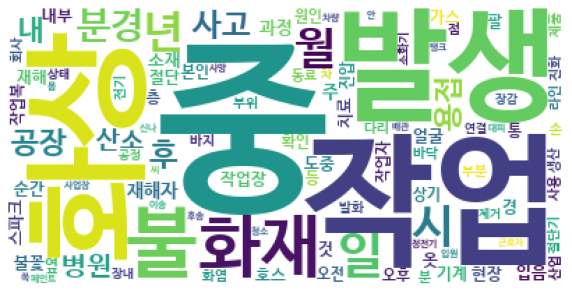

In [38]:
# wordcloud 패키지 다운로드
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nouns = []
for post in 화재_post:
    for noun in tagger.nouns(post):
        nouns.append(noun)
num_top_nouns = 100
nouns_counter = Counter(nouns)
top_nouns = dict(nouns_counter.most_common(num_top_nouns)[:200])
print(top_nouns)

wc = WordCloud(background_color="white", font_path='/Users/byeonghyeon/Documents/GitHub/IndustrialSystemsEngineering_Project/font/NanumBarunGothicBold.ttf')
wc.generate_from_frequencies(top_nouns)
# World
# 많이 나타나는 단어일수록 크게 나타남

figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)
wc.to_file(filename="WC_ENTIRE.png") # to_file 함수
tagger = Mecab()

# posts

In [50]:
# 첫번째 tokenizer(Okt)
def tokenizer_1(raw_texts, pos=["Noun","Alpha","Verb","Number"], stop_words=list(df_stopwords.get("불용어"))):
    okt = Okt()
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(화재_post.iloc[0])
print(tokenizer_1(화재_post.iloc[0]))

주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징 기계를 이용하여 작업하던 중 가우징 불똥이 내경 단차부위에 두딪혀 작업자 쪽으로 뛰어 점퍼에 불이 붙었으나, 방독마스크와 용접면을 쓰고 있어서 불이 붙은 줄 모르다가 늦게 인지하여 왼쪽팔과 가슴쪽에 화염화상을 입음.
['초크', '붙다', '두딪혀', '뛰다', '붙다', '쓰다', '붙다', '늦다', '왼쪽']


In [52]:
# 두번째 tokenizer(mecab)
def tokenizer_2(raw_texts, stop_words=list(df_stopwords.get("불용어"))):
    nouns = []
    for noun in tagger.nouns(raw_texts):
        if noun not in stop_words and len(noun)>1:
            nouns.append(noun)
    return nouns

print(화재_post.iloc[0])
print(tokenizer_2(화재_post.iloc[0]))

주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징 기계를 이용하여 작업하던 중 가우징 불똥이 내경 단차부위에 두딪혀 작업자 쪽으로 뛰어 점퍼에 불이 붙었으나, 방독마스크와 용접면을 쓰고 있어서 불이 붙은 줄 모르다가 늦게 인지하여 왼쪽팔과 가슴쪽에 화염화상을 입음.
['주조사', '업장', '우징', '초크', '안쪽', '소착', '제거', '우징', '기계', '우징', '불똥', '내경', '단차', '부위', '점퍼', '방독', '마스크', '용접면', '인지', '가슴', '화상']


In [55]:
# 세번째 tokenizer(Okt)
def tokenizer_3(raw_texts, pos=["Noun"], stop_words=list(df_stopwords.get("불용어"))):
    okt = Okt()
    p = okt.pos(raw_texts, 
            norm=True,   # 정규화(normalization)
            stem=True    # 어간추출(stemming)
            )
    o = [word for word, tag in p if len(word) > 1 and tag in pos and word[0] not in stop_words]
    return(o)

print(화재_post.iloc[0])
print(tokenizer_3(화재_post.iloc[0]))

주조사업장내 가우징 작업장에서 롤초크 안쪽에 붙어있는 소착을 제거하기 위해서 가우징 기계를 이용하여 작업하던 중 가우징 불똥이 내경 단차부위에 두딪혀 작업자 쪽으로 뛰어 점퍼에 불이 붙었으나, 방독마스크와 용접면을 쓰고 있어서 불이 붙은 줄 모르다가 늦게 인지하여 왼쪽팔과 가슴쪽에 화염화상을 입음.
['초크', '두딪혀', '왼쪽']


In [131]:
tfidfv = TfidfVectorizer(
    tokenizer = tokenizer_2, # 문장에 대한 tokenizer (위에 정의한 함수 이용)
    min_df = 5,            # 단어가 출현하는 최소 문서의 개수
    sublinear_tf = True,    # tf값에 1+log(tf)를 적용하여 tf값이 무한정 커지는 것을 막음
    stop_words = list(df_stopwords.get("불용어"))
)
X = tfidfv.fit_transform(화재_post)
X_df = pd.DataFrame(X.toarray(), columns = tfidfv.get_feature_names())
X_df # TF-IDF DTM

,가공,가동,가량,가스,가스통,가슴,가열,감지기,강서구,개방,...,회사,회수,회전,후송,휘발,휘발유,휴대,휴식,흡입,히터
0,0.0,0.000000,0.0,0.000000,0.0,0.366571,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.144815,0.0,0.0,0.0,0.0,0.0,0.236901,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.199297,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,0.0,0.440546,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
969,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
970,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
971,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.301217,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [130]:
print(len(tfidfv.vocabulary_))
tfidfv.get_feature_names()

576


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['가공',
 '가동',
 '가량',
 '가스',
 '가스통',
 '가슴',
 '가열',
 '감지기',
 '강서구',
 '개방',
 '개폐',
 '거제시',
 '건물',
 '건조',
 '걸레',
 '검사',
 '겨드랑',
 '견해',
 '결과',
 '결함',
 '경고',
 '경기',
 '경기도',
 '경남',
 '경보음',
 '경북',
 '경유',
 '경화',
 '계단',
 '고성군',
 '고성읍',
 '고압',
 '고온',
 '고인',
 '고장',
 '고정',
 '고철',
 '공간',
 '공구',
 '공급',
 '공기',
 '공단',
 '공동',
 '공사',
 '공업',
 '공장장',
 '공정',
 '과열',
 '과장',
 '관계',
 '관리',
 '관리자',
 '광개토',
 '광주시',
 '교반',
 '교체',
 '교환',
 '구로',
 '구멍',
 '구조',
 '그라인더',
 '근무',
 '근무자',
 '근무처',
 '근처',
 '금속',
 '금요일',
 '금형',
 '기계',
 '기기',
 '기름',
 '기름때',
 '기름통',
 '기사',
 '기숙사',
 '기업',
 '기인',
 '긴급',
 '김천',
 '김해시',
 '깡통',
 '나무',
 '난로',
 '납품',
 '내용',
 '내원',
 '냄새',
 '노출',
 '높이',
 '누수',
 '누유',
 '누전',
 '누출',
 '다발',
 '단계',
 '담당자',
 '담배',
 '당사',
 '당시',
 '당일',
 '당황',
 '대구',
 '대우',
 '대피',
 '대학교',
 '대형',
 '도구',
 '도로',
 '도료',
 '도움',
 '도장',
 '도착',
 '도포',
 '도형제',
 '동시',
 '뒤쪽',
 '드럼',
 '드럼통',
 '때문',
 '뚜껑',
 '라이타',
 '라이터',
 '라인',
 '록지',
 '마그네슘',
 '마당',
 '마무리',
 '마음',
 '마찰',
 '머리',
 '먼지',
 '메탄올',
 '면부',
 '모터',
 '목격',
 '목요일',
 '목적',
 '무기',
 

In [132]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

tfidf_df = pd.DataFrame(X.toarray())
# 2번째와 3번째 문서(유클리디안 거리 값)
print(euclidean_distances(X[1], X[2]))#, X)
# 2번째와 3번째 문서(코사인유사도 값)
print(cosine_similarity(X[1], X[0]))#, X)
# [[0.1837195]]

[[1.00741097]]
[[0.04215434]]


In [155]:
# 시간 오래걸림
cosine_result = []
for x in range(len(화재_post)):
    tmp = []
    for y in range(len(화재_post)):
        tmp.append(cosine_similarity(X[x], X[y])[0][0])
    cosine_result.append(tmp)
    
# 모든 조에 해당하는 cosine similarity 결과 값을
# DataFrame 형태로 변환
cosine_result_df = pd.DataFrame(cosine_result)
cosine_result_df
    

,0,1,2,3,4,5,6,7,8,9,...,963,964,965,966,967,968,969,970,971,972
0,1.000000,0.042154,0.005365,0.005161,0.063488,0.000000,0.016924,0.037787,0.000000,0.000000,...,0.012679,0.000000,0.097662,0.012675,0.000000,0.089792,0.016249,0.009639,0.008776,0.008776
1,0.042154,1.000000,0.492562,0.444390,0.389877,0.135208,0.122609,0.155168,0.045292,0.000000,...,0.006716,0.000000,0.074205,0.006714,0.093614,0.047560,0.008606,0.005105,0.004648,0.004648
2,0.005365,0.492562,1.000000,0.657461,0.405774,0.165792,0.008202,0.018314,0.073028,0.000000,...,0.006145,0.000000,0.004123,0.006143,0.036590,0.006053,0.147407,0.004671,0.022341,0.022341
3,0.005161,0.444390,0.657461,1.000000,0.371848,0.119006,0.007890,0.017616,0.039865,0.000000,...,0.005911,0.033379,0.023748,0.005909,0.000000,0.005823,0.007575,0.004494,0.004091,0.004091
4,0.063488,0.389877,0.405774,0.371848,1.000000,0.104298,0.121422,0.032401,0.049085,0.043327,...,0.031389,0.048011,0.007295,0.041554,0.059297,0.010709,0.013933,0.085883,0.022773,0.022773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,0.089792,0.047560,0.006053,0.005823,0.010709,0.000000,0.019094,0.042633,0.000000,0.000000,...,0.014305,0.000000,0.110187,0.014301,0.082535,1.000000,0.018332,0.010875,0.090009,0.090009
969,0.016249,0.008606,0.147407,0.007575,0.013933,0.000000,0.024842,0.055466,0.000000,0.000000,...,0.018610,0.000000,0.012488,0.018605,0.045867,0.018332,1.000000,0.014148,0.012881,0.012881
970,0.009639,0.005105,0.004671,0.004494,0.085883,0.000000,0.014736,0.032902,0.068518,0.000000,...,0.011039,0.000000,0.007407,0.076429,0.065628,0.010875,0.014148,1.000000,0.007641,0.007641
971,0.008776,0.004648,0.022341,0.004091,0.022773,0.000000,0.013416,0.029956,0.000000,0.000000,...,0.010051,0.000000,0.006744,0.010048,0.017906,0.090009,0.012881,0.007641,1.000000,1.000000


In [156]:
cosine_result_df.to_excel("min_df5_cos_sim.xlsx")

In [161]:
target = 110
y_cosine = cosine_result_df[target - 1]
dic ={}
for i in range(len(y_cosine)):
    dic[i+1] = y_cosine[i]
#8조와 비슷한 조 찾기 위함
# euclidean distance 를 dic에 씌워 sorting 함(1부터 10위까지)
sorted(dic.items(), key=lambda x: x[1], reverse = True)[0:20]

[(110, 1.0),
 (725, 0.46077385754135425),
 (779, 0.34866907404543407),
 (45, 0.33455334027079386),
 (154, 0.31010308529950936),
 (481, 0.3084497968797386),
 (478, 0.2963425697074282),
 (845, 0.2480623827986386),
 (866, 0.2480623827986386),
 (844, 0.2419083066363298),
 (964, 0.23495335506923934),
 (462, 0.23479582627863324),
 (929, 0.2337605647003258),
 (479, 0.21093275644002746),
 (480, 0.20721140828775841),
 (436, 0.20049120857905162),
 (343, 0.2001651788990105),
 (329, 0.19635054487369064),
 (552, 0.19140078677378494),
 (554, 0.19140078677378494)]

In [86]:
m = TSNE(learning_rate = 50,random_state=1)
tsne_features = m.fit_transform(pd.DataFrame(X.toarray()))
tsne_features

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


array([[  2.8539226 ,  -0.26859024],
       [ 29.242294  ,  28.743786  ],
       [ 30.678082  ,  29.490494  ],
       ...,
       [  8.42788   ,   7.5057306 ],
       [-10.92345   , -22.440987  ],
       [-10.92345   , -22.440987  ]], dtype=float32)

In [87]:
df_tsne = pd.DataFrame()
df_tsne['x'] = tsne_features[:,0]
df_tsne['y'] = tsne_features[:,1]

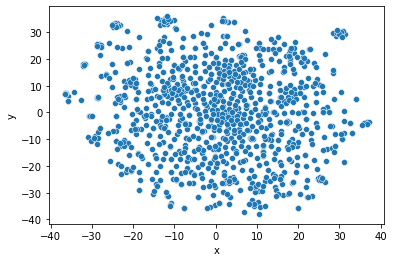

In [88]:
sns.scatterplot(x="x",y="y",data = df_tsne)
plt.show()

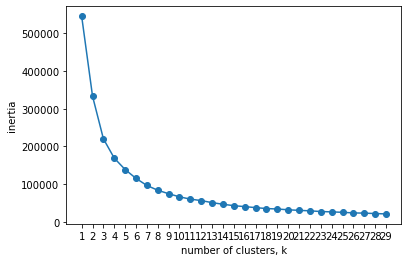

In [135]:
ks = range(1,30)

inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
#     model.fit(X.toarray()) # 축소 안한 inertia
    model.fit(tsne_features) # tsne한 놈
    inertias.append(model.inertia_)
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


In [137]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)
kmeans

# 모델에 fitting 하기
# kmeans.fit(tsne_features) # 축소된놈 Fitting
kmeans.fit(X.toarray()) # 축소 안한놈 Fitting


# y_kmeans = kmeans.predict(tsne_features)
y_kmeans = kmeans.predict(X.toarray())

y_kmeans[0:10] # 군집화 된 결과


array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2], dtype=int32)

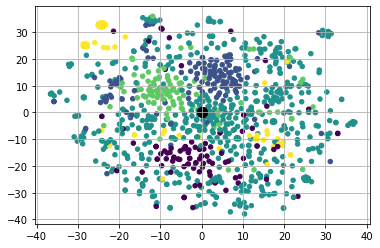

In [143]:
plt.scatter(np.array(tsne_features)[:,0], np.array(tsne_features)[:,1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.show()


In [144]:
clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [df_화재['연번'].iloc[idx]]
    else:
        clustered_dic[i].append(df_화재['연번'].iloc[idx])
clustered_dic
# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num

df_cluster


,num,clusters,cluster_num
0,0,"[10655, 19655, 34939, 34945, 35041, 40593, 405...",95
1,1,"[1388, 7567, 11171, 11401, 12572, 18289, 27241...",131
2,2,"[43, 636, 672, 963, 1973, 3112, 3294, 4276, 51...",586
3,3,"[7286, 13224, 16312, 20055, 21544, 27316, 2948...",109
4,4,"[29671, 29763, 29764, 29776, 29777, 29778, 297...",52


In [154]:
label = df_cluster.iloc[0].clusters
for key in df_cluster.iloc[0].clusters:
    print(df_화재[df_화재["연번"] == key]["재해개요"])

44    차량해체 작업 공정중에 머플러 절단작업을 하다가 연료통이 절단이 되어 휘발유에 불이...
Name: 재해개요, dtype: object
82    사고 당시자는 휴식시간에 난로 옆에서 휴식을 취하던중 작업자의 의복이 발화 되었으며...
Name: 재해개요, dtype: object
163    20시00분에 출근하여 근무 중 2012년4월28일01시00분경에 회사 내 참마루 ...
Name: 재해개요, dtype: object
164    20시00분에 출근하여 근무도중 2012년4월28일01시00분경에 회사 내 참마루 ...
Name: 재해개요, dtype: object
166    20시00분에 출근하여 근무 중 2012년4월28일01시00분경에 회사 내 참마루 ...
Name: 재해개요, dtype: object
179    발생시간:2012년 05월 21일 17시경 \n발생장소: 경기도 광주시 초월읍 선동...
Name: 재해개요, dtype: object
180    발생시간: 2012년 05월 21일 17시경\n발생장소: 경기도 광주시 초월읍 선동...
Name: 재해개요, dtype: object
184    배치로 2호기 2호기 정기점검차 배치로 가동중단을 하던 중 냉각실 안쪽 벽에 약간의...
Name: 재해개요, dtype: object
189    2012년 5월 25일 18시경 성형9호기 YF D/B INR PR MLG'G라인 ...
Name: 재해개요, dtype: object
233    2012년 06월 25일 오후 4시경에 (김경수)왁스를 추출하는 경우에 자연발하되어...
Name: 재해개요, dtype: object
234    2012년 6월25일 오후 4시경에 왁스를 추출하는 경우에 자연발하되어 소화기로 불...
Name: 재해개요, dtype: object
282    2012.07.25 새벽 기상 후 마당에 나왔다가 공장내부에 불이 난것으로 의심되어...
Name: 재해개요, dtype: object
325   